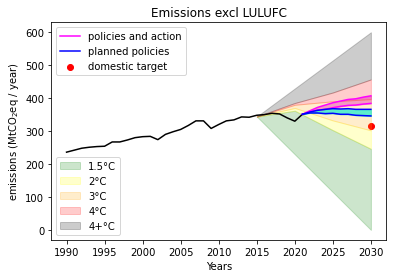

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/Users/samsuidman/Desktop/neurophysics/energy and climate/Week 6 grafieken - Blad1.csv",index_col=1).T
data = df[df.keys()[[0,2,3,4,5]]]
titles = data.keys()

df2 = pd.read_csv("/Users/samsuidman/Desktop/neurophysics/energy and climate/ranges for paris.csv",delimiter="\t").T



fig,ax = plt.subplots()
emissions = []
for i,title in enumerate(titles):
    years = data[title].index[1:].astype(int)
    emission = data[title].array[1:].astype(float)
    emissions.append(emission)
    if i==0:
        # A = ax.plot(years,emission,label='historical data',color='black')
        A = ax.plot(years,emission,color='black')
    if i==1:
        B = ax.plot(years,emission,label='policies and action',color='magenta')
    if i==2:
        C = ax.plot(years,emission,color='magenta')
    if i==3:
        D = ax.plot(years,emission,label='planned policies',color='blue')
    if i==4:
        E = ax.plot(years,emission,color='blue')

ax.fill_between(years,emissions[1],emissions[2],color='violet',alpha=0.8)
ax.fill_between(years,emissions[3],emissions[4],color='cyan',alpha=0.8)

ax.scatter(2030,315.9,color='red',label='domestic target')

titles_2 = df2.T["Upper_end_of"].array
years_2 = df2.index[1:].astype(int).array
emissions_2 = [df2[j][1:].array.astype(float) for j in range(len(titles_2))]
one = ax.fill_between(years_2[:16],np.linspace(344.1,0,16),emissions_2[0][:16],color='green',alpha=0.2)
two = ax.fill_between(years_2[:16],emissions_2[0][:16],emissions_2[1][:16],color='yellow',alpha=0.2)
three = ax.fill_between(years_2[:16],emissions_2[1][:16],emissions_2[2][:16],color='orange',alpha=0.2)
four = ax.fill_between(years_2[:16],emissions_2[2][:16],emissions_2[3][:16],color='red',alpha=0.2)
five = ax.fill_between(years_2[:16],emissions_2[3][:16],np.linspace(344.1,600,16),color='black',alpha=0.2)

ax.set_xlabel('Years')
ax.set_ylabel('emissions (MtCO$_{2}$eq / year)')
ax.set_title('Emissions excl LULUFC')

legend2 = plt.legend([one,two,three,four,five],['1.5°C','2°C','3°C','4°C','4+°C'],loc=3)
ax.legend(loc=2)
ax.add_artist(legend2)
fig.savefig("/Users/samsuidman/Desktop/neurophysics/energy and climate/Week 6 figure.jpeg",dpi=500)
